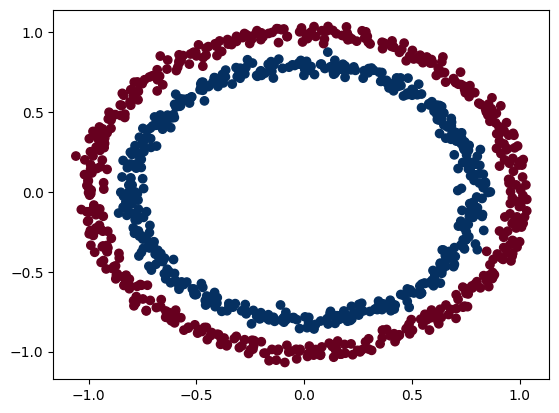

In [77]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
                    noise=0.03,
                    random_state=42,
                   )

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)

In [78]:
import torch
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"
device

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [79]:
from torch import nn
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.layer_1(x))))

model = CircleModel().to(device)
model

CircleModel(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [80]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [81]:
torch.manual_seed(42)
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train,
                      y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        model.eval()
        with torch.inference_mode():
            test_logits = model(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))
            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_true=y_test,
                                   y_pred=test_pred)
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69833, Accuracy: 50.00% | Test Loss: 0.69863, Test Accuracy: 49.00%
Epoch: 100 | Loss: 0.69289, Accuracy: 50.88% | Test Loss: 0.69411, Test Accuracy: 47.00%
Epoch: 200 | Loss: 0.69015, Accuracy: 53.37% | Test Loss: 0.69141, Test Accuracy: 50.00%
Epoch: 300 | Loss: 0.68762, Accuracy: 56.62% | Test Loss: 0.68828, Test Accuracy: 55.00%
Epoch: 400 | Loss: 0.68469, Accuracy: 60.00% | Test Loss: 0.68469, Test Accuracy: 61.00%
Epoch: 500 | Loss: 0.67985, Accuracy: 56.00% | Test Loss: 0.67890, Test Accuracy: 60.50%
Epoch: 600 | Loss: 0.67280, Accuracy: 56.00% | Test Loss: 0.67176, Test Accuracy: 60.50%
Epoch: 700 | Loss: 0.66304, Accuracy: 64.50% | Test Loss: 0.66452, Test Accuracy: 65.00%
Epoch: 800 | Loss: 0.64710, Accuracy: 74.12% | Test Loss: 0.65300, Test Accuracy: 71.50%
Epoch: 900 | Loss: 0.62182, Accuracy: 81.62% | Test Loss: 0.63241, Test Accuracy: 78.00%


In [82]:
model.eval()
with torch.inference_mode():
    y_preds=torch.round(torch.sigmoid(model(X_test))).squeeze()
y_preds[:10], y[:10]

(tensor([1., 1., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

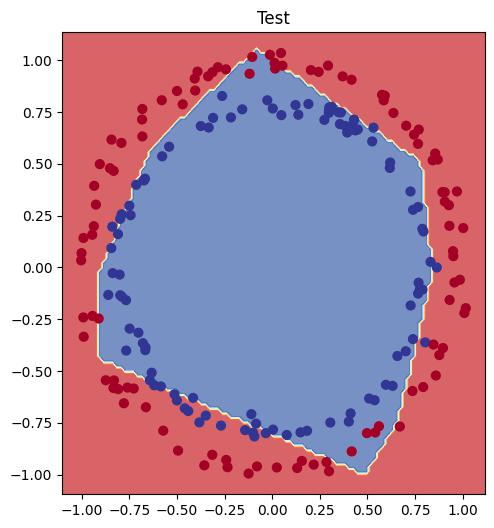

In [83]:
# Plot decision boundaries for training and test sets
from helper_functions import plot_predictions, plot_decision_boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test) # model_3 = has non-linearity